SOLAR POWER FORECASTING - IMPROVED VERSION

[1/7] Loading PV data from S3...
Found 10 files. Loading data...
Identified timestamp column: 'Unnamed: 0'
Successfully loaded 3160 rows of PV data
Date range: 2016-04-27 00:00:00 to 2025-02-11 00:00:00

[2/7] Loading NSRDB weather data...
Loading 9 NSRDB files...
Loaded 78912 hourly weather records

[3/7] Aggregating weather data to daily...
Aggregated to 3288 daily records

[4/7] Cleaning and engineering features...
PV data cleaned and validated
Combined dataset: 3134 rows from 2016-04-27 00:00:00 to 2024-12-01 00:00:00
After feature engineering: 3121 rows (13 dropped due to NaN)
Total features: 49

Final dataset shape: (3121, 49)
Features created: 49

[5/7] Preparing features and target...
Forecast features: 40
Sample features: ['Day_of_Year', 'Day_of_Week', 'Month', 'Week_of_Year', 'sin_day', 'cos_day', 'is_weekend', 'Power_Mean_lag_1D', 'Power_Mean_lag_2D', 'Power_Mean_lag_3D']

Training set: 2496 samples
Test set: 625 samples
Test perio

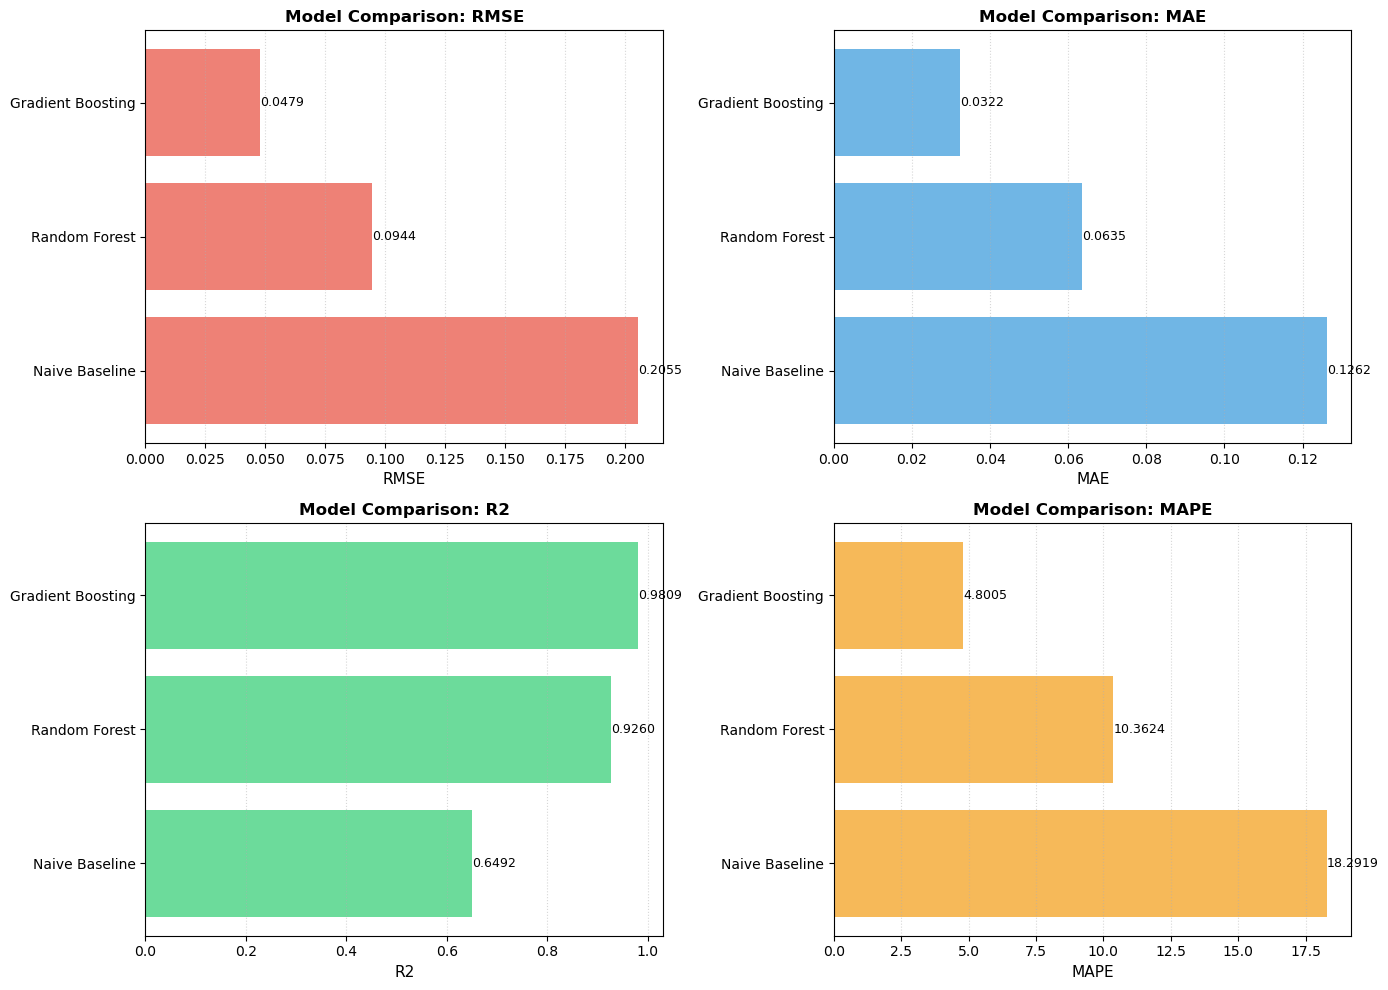


MODEL COMPARISON SUMMARY
                       RMSE       MAE        R2  Correlation       MAPE
Naive Baseline     0.205458  0.126216  0.649171     0.824409  18.291920
Random Forest      0.094361  0.063534  0.926000     0.963824  10.362411
Gradient Boosting  0.047914  0.032215  0.980921     0.990561   4.800462

Best model: Gradient Boosting (R² = 0.9809)

Creating prediction plots...


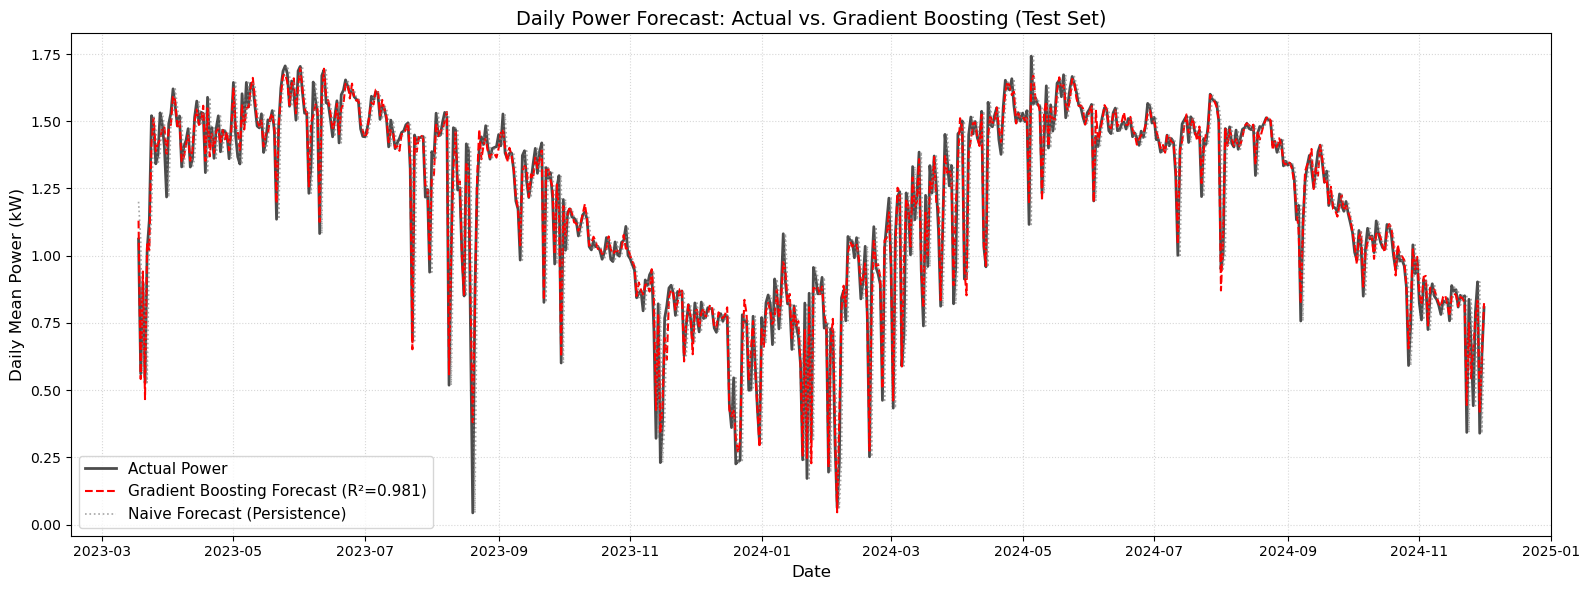

Creating residual plots...


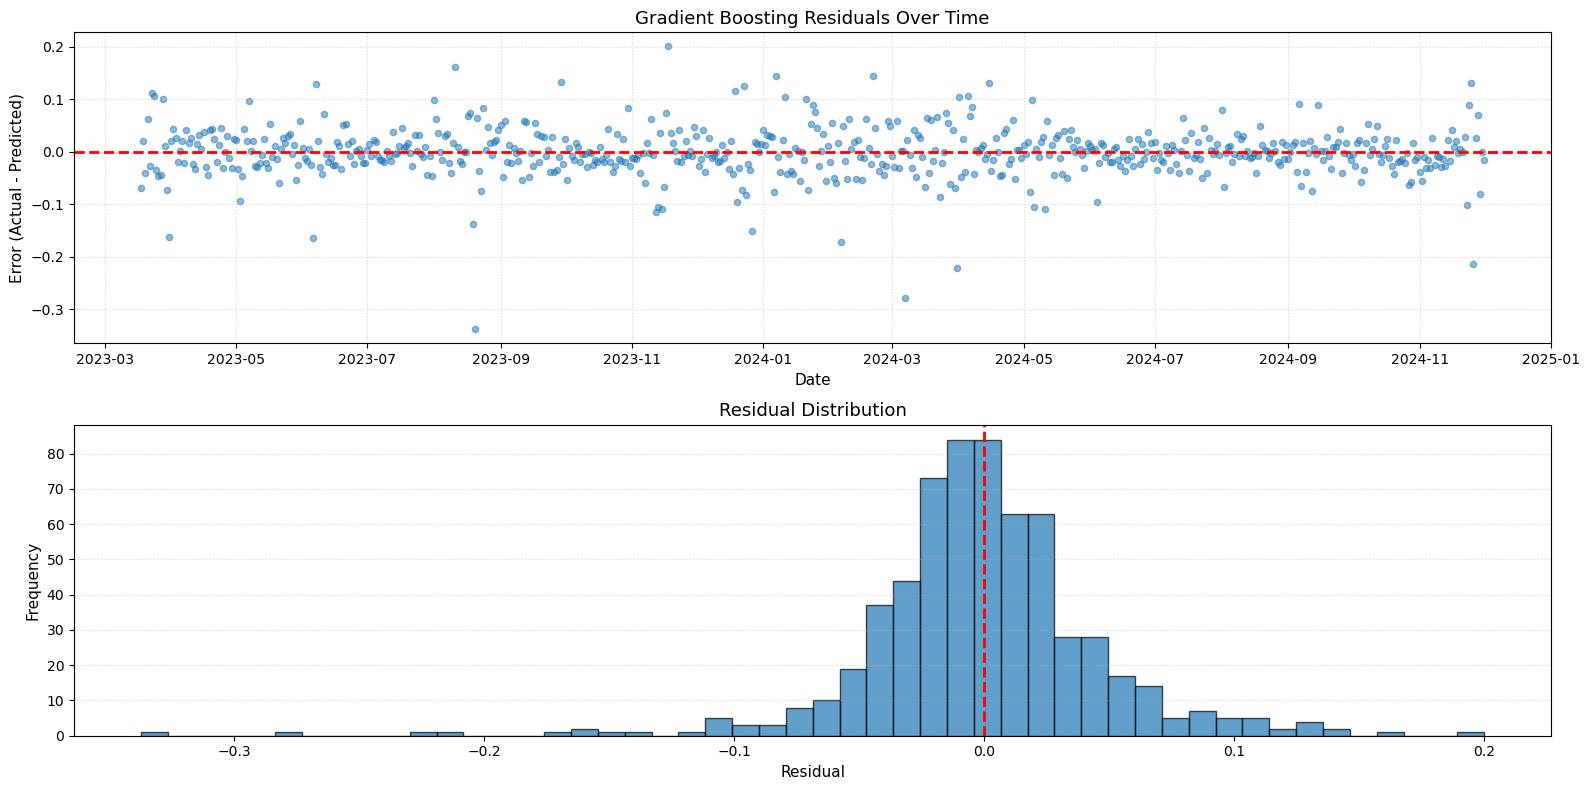

Creating feature importance plots...


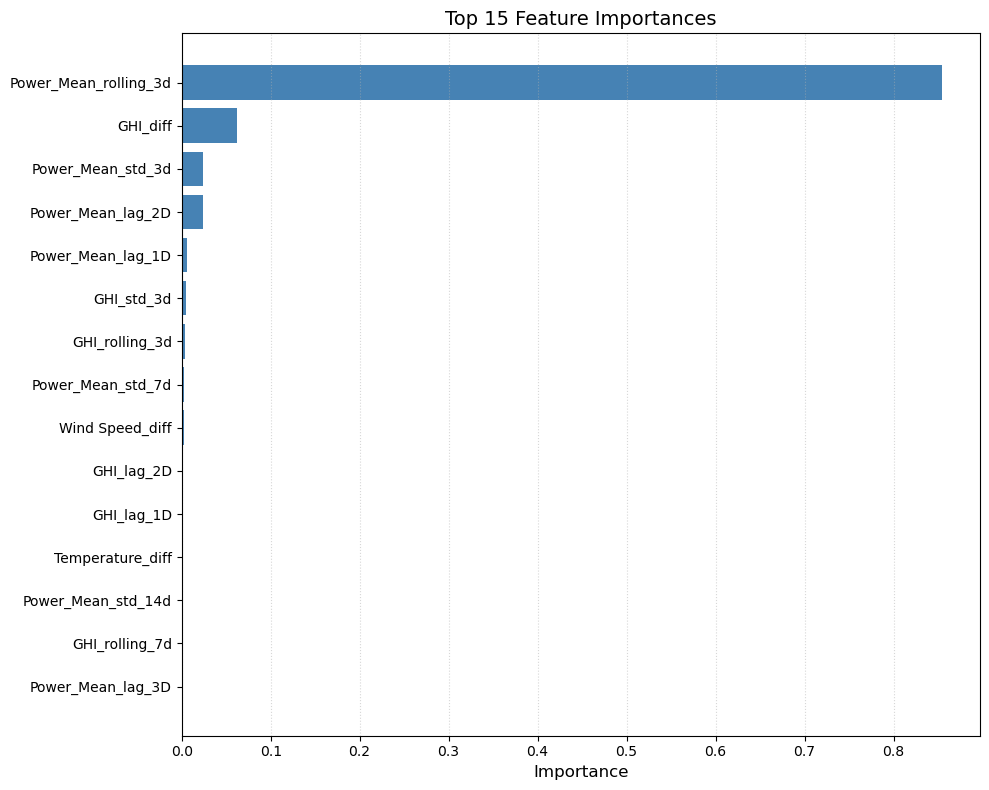

Performing SHAP analysis (this may take a moment)...


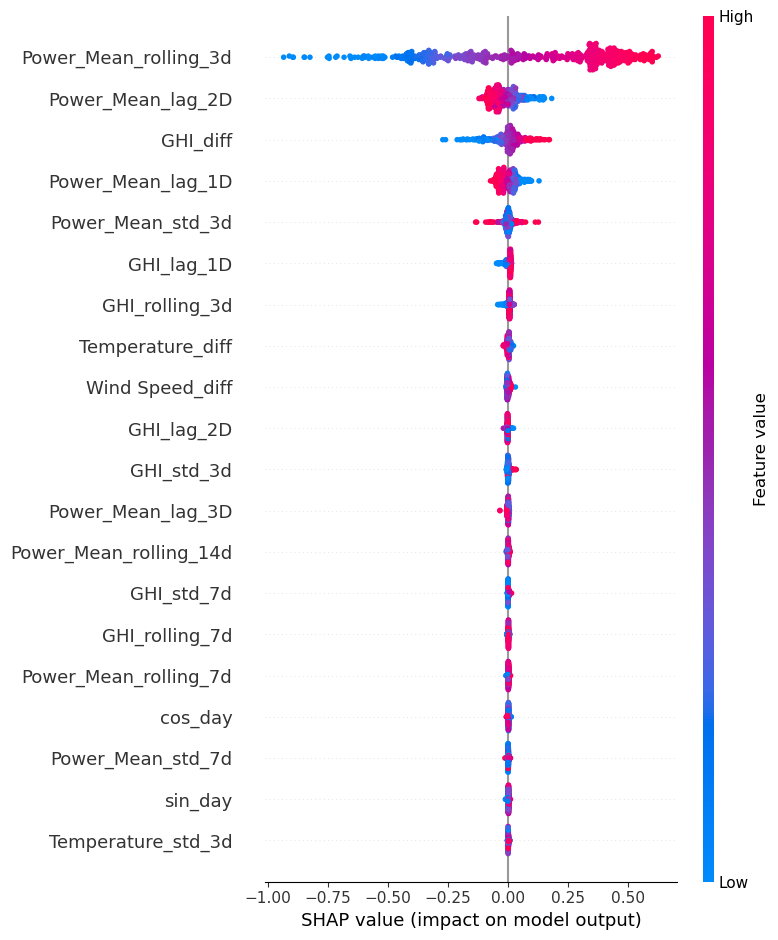

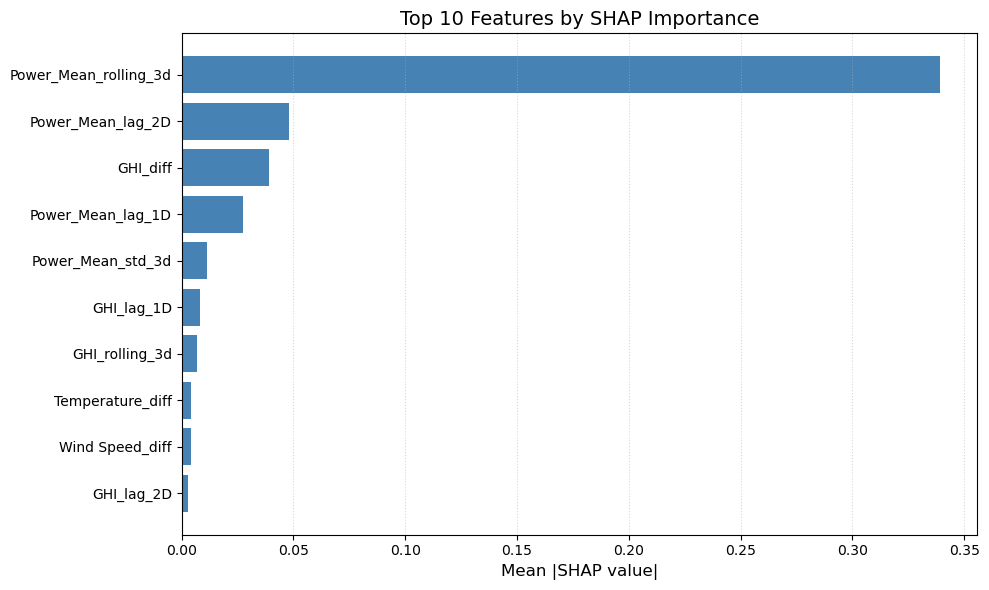

Analyzing seasonal performance...


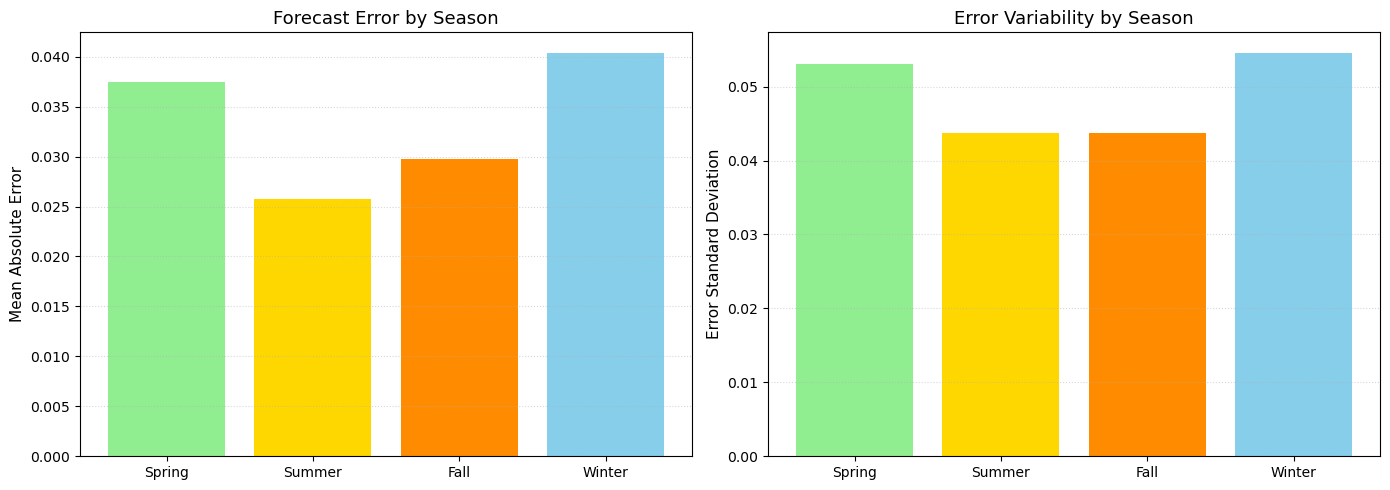


Seasonal Performance Metrics:
        AbsError     Error
Season                    
Spring  0.037507  0.053007
Summer  0.025706  0.043710
Fall    0.029794  0.043719
Winter  0.040416  0.054611

TOP 5 DAYS WITH LARGEST FORECAST ERRORS
              Actual  Predicted     Error    PctError
Date                                                 
2023-08-20  0.043400   0.380720 -0.337320  777.235449
2024-03-07  0.708481   0.986567 -0.278086   39.250958
2024-03-31  0.958973   1.180621 -0.221648   23.113015
2024-11-26  0.442054   0.656148 -0.214094   48.431546
2023-11-18  0.813366   0.613216  0.200150   24.607617

FORECAST SUMMARY

Target Variable: Power_Mean
Training Period: 2016-05-10 00:00:00 to 2023-03-17 00:00:00
Test Period: 2023-03-18 00:00:00 to 2024-12-01 00:00:00

Best Model: Gradient Boosting
  - RMSE: 0.0479
  - MAE: 0.0322
  - R²: 0.9809
  - MAPE: 4.80%
  - Skill Score: 0.7668

ANALYSIS COMPLETE - All visualizations saved!

✓ Pipeline execution complete!

To access results:
  - Mod

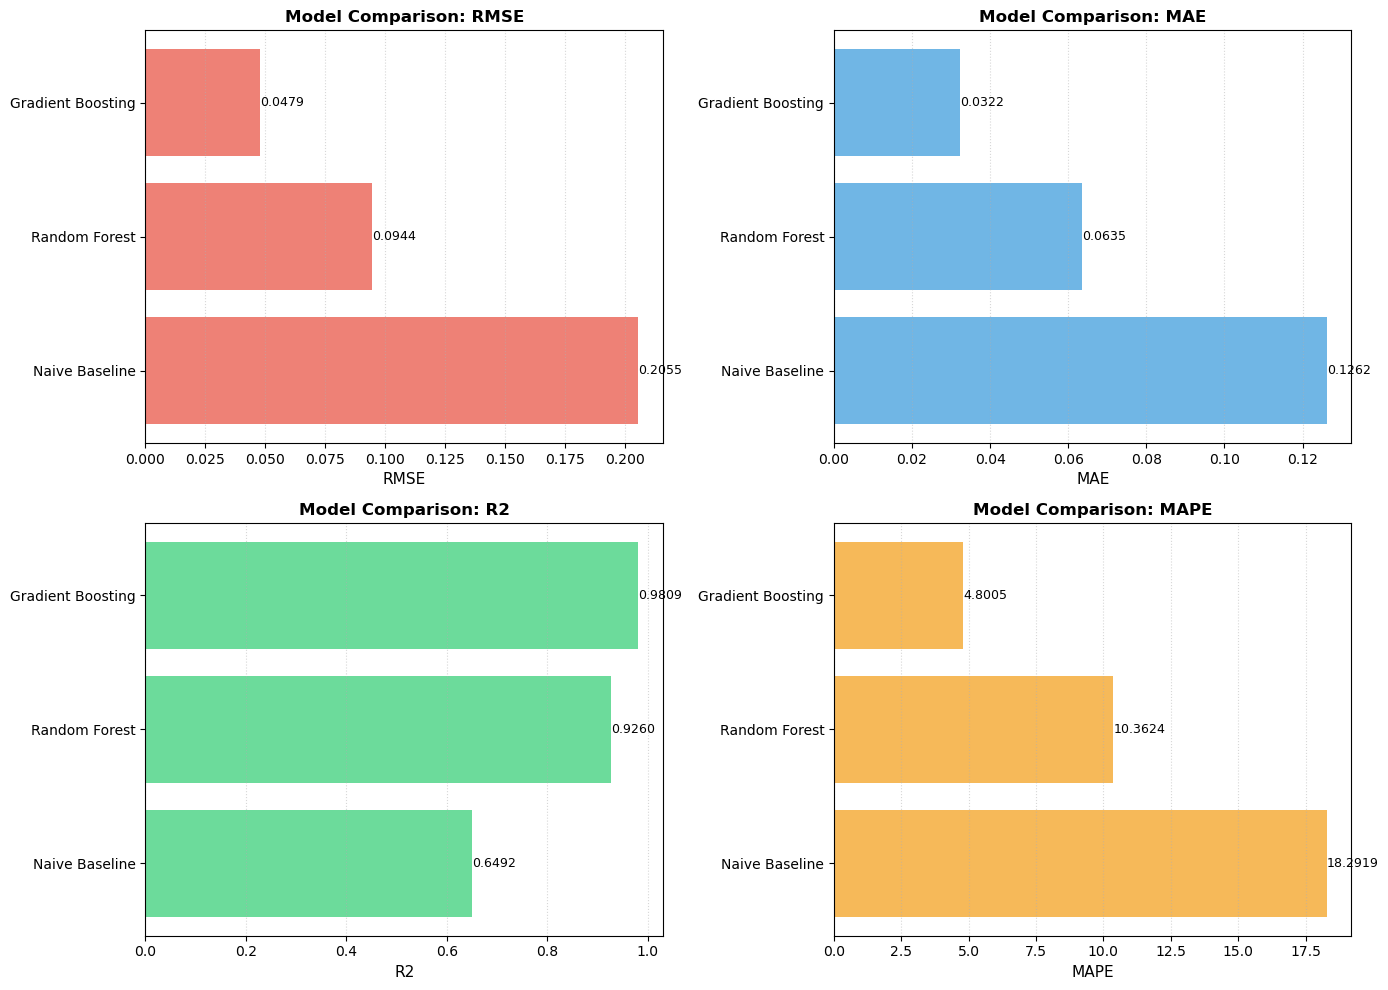


MODEL COMPARISON SUMMARY
                       RMSE       MAE        R2  Correlation       MAPE
Naive Baseline     0.205458  0.126216  0.649171     0.824409  18.291920
Random Forest      0.094361  0.063534  0.926000     0.963824  10.362411
Gradient Boosting  0.047914  0.032215  0.980921     0.990561   4.800462

Best model: Gradient Boosting (R² = 0.9809)

Creating prediction plots...


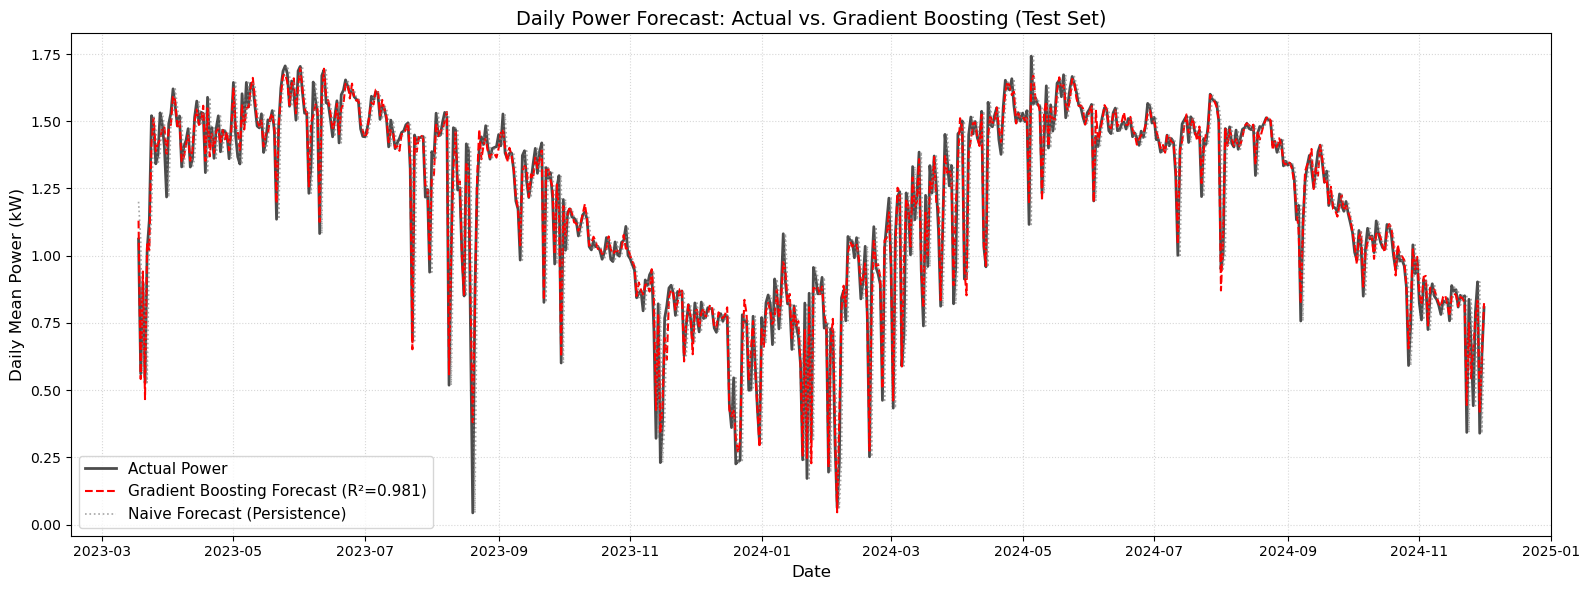

Creating residual plots...


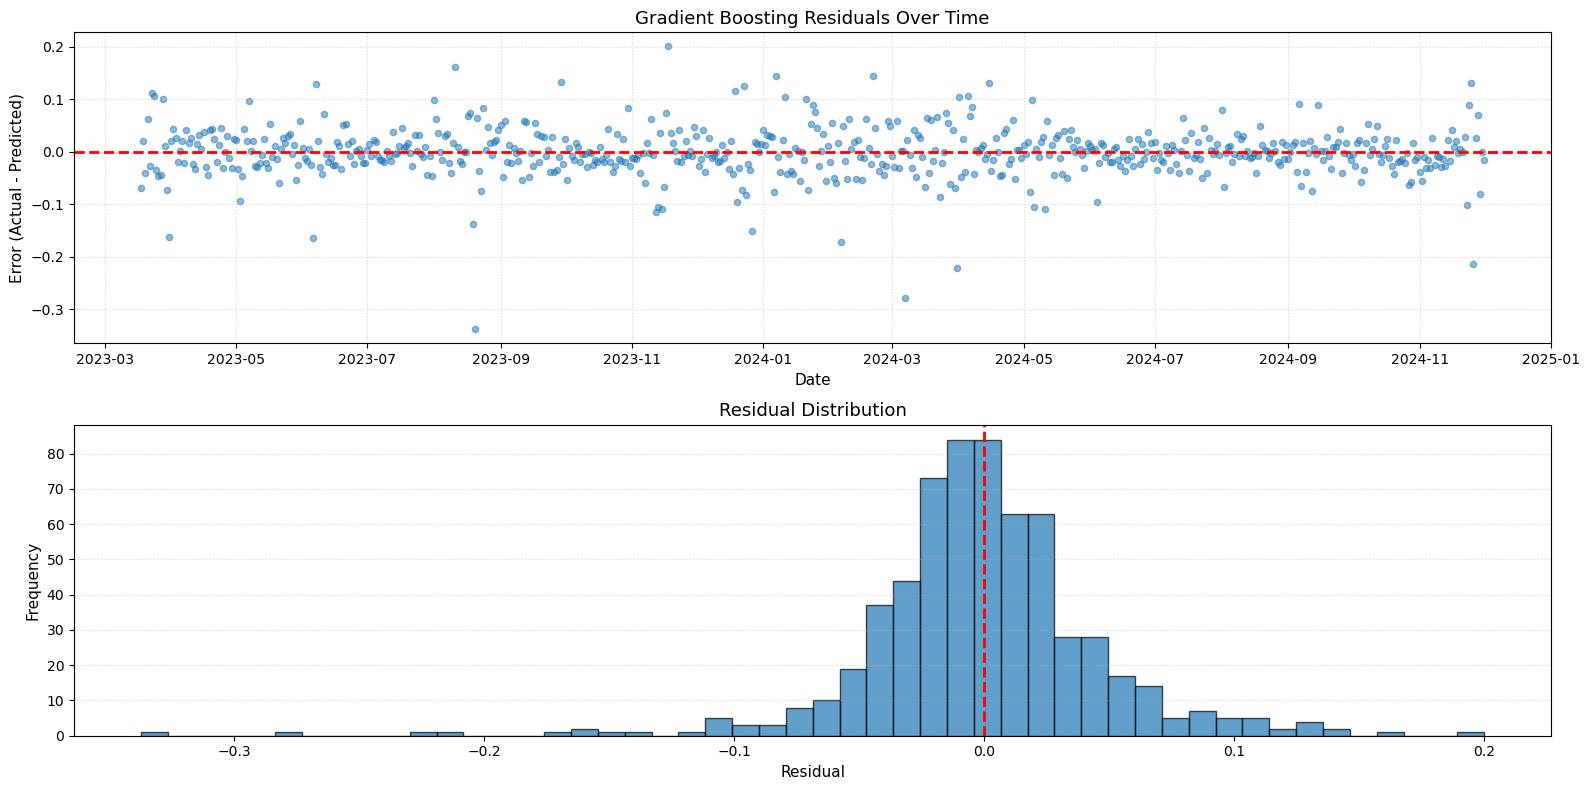

Creating feature importance plots...


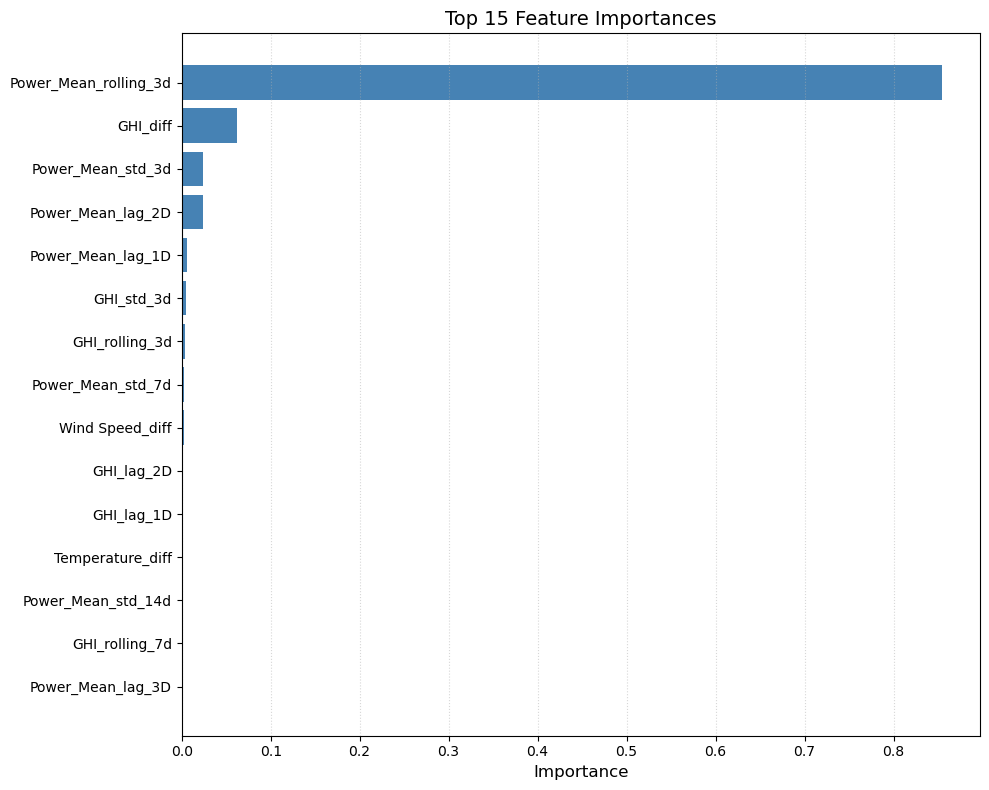

Performing SHAP analysis (this may take a moment)...


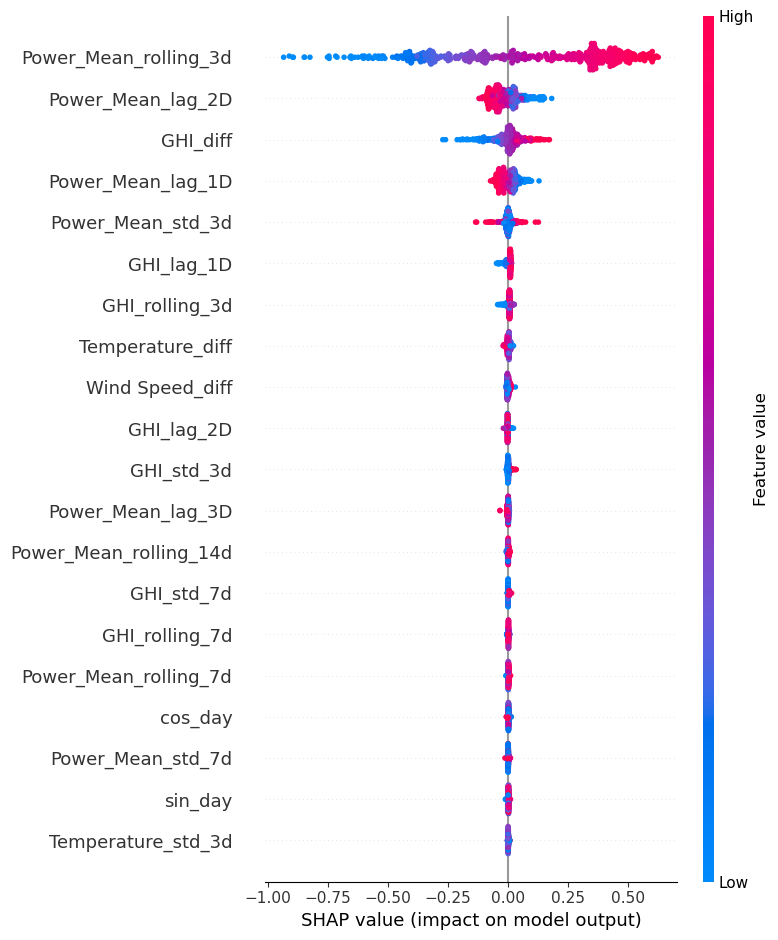

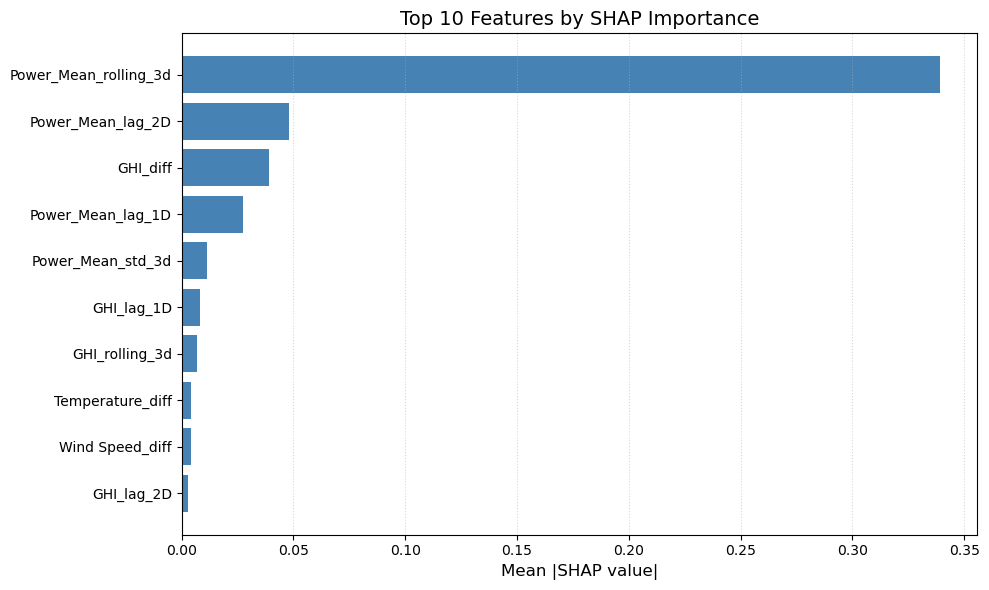

Analyzing seasonal performance...


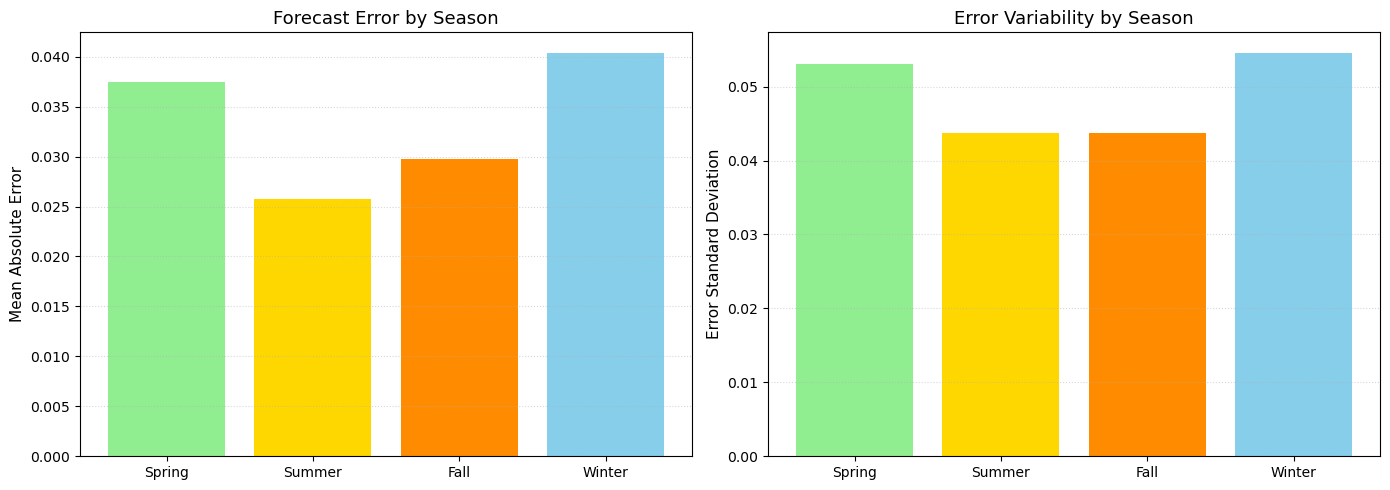


Seasonal Performance Metrics:
        AbsError     Error
Season                    
Spring  0.037507  0.053007
Summer  0.025706  0.043710
Fall    0.029794  0.043719
Winter  0.040416  0.054611

TOP 5 DAYS WITH LARGEST FORECAST ERRORS
              Actual  Predicted     Error    PctError
Date                                                 
2023-08-20  0.043400   0.380720 -0.337320  777.235449
2024-03-07  0.708481   0.986567 -0.278086   39.250958
2024-03-31  0.958973   1.180621 -0.221648   23.113015
2024-11-26  0.442054   0.656148 -0.214094   48.431546
2023-11-18  0.813366   0.613216  0.200150   24.607617

FORECAST SUMMARY

Target Variable: Power_Mean
Training Period: 2016-05-10 00:00:00 to 2023-03-17 00:00:00
Test Period: 2023-03-18 00:00:00 to 2024-12-01 00:00:00

Best Model: Gradient Boosting
  - RMSE: 0.0479
  - MAE: 0.0322
  - R²: 0.9809
  - MAPE: 4.80%
  - Skill Score: 0.7668

ANALYSIS COMPLETE - All visualizations saved!


In [1]:
"""
Solar Power Forecasting with Random Forest and Gradient Boosting
Author: Joey Bahret
Date: November 11, 2025

This script forecasts daily solar power production using historical PV data
and meteorological features from NSRDB. Improvements include better feature
engineering, multiple models, comprehensive evaluation, and proper code structure.
"""

import pandas as pd
import numpy as np
import s3fs
import io
import requests
import urllib.parse
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    # Data sources
    's3_base_uri': 's3://oedi-data-lake/pvdaq/csv/pvdata/system_id=11487/',
    'nrel_api_key': 'kqrttpYYUcxix5pCW7wO5pysSE8wJ0XaYShbxnDf',
    'nrel_email': 'jbahret2@illinois.edu',
    'nrel_base_url': 'https://developer.nrel.gov/api/nsrdb/v2/solar/nsrdb-GOES-aggregated-v4-0-0-download.json?',
    'location_id': '205581',
    'data_directory': '/Users/joeybahret/Documents/Grad_School/ATMS_523/Module 8/nsrdb_data/',
    
    # Model parameters
    'target_column': 'Power_Mean',
    'train_split': 0.8,
    'random_state': 42,
    
    # Feature engineering
    'rolling_windows': [3, 7, 14],
    'lag_days': [1, 2, 3],
}

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_pv_data_from_s3(s3_uri, verbose=True):
    """
    Load PV data from S3 bucket and combine all CSV files.
    
    Parameters:
    -----------
    s3_uri : str
        Base S3 URI for the PV data
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    pd.DataFrame
        Combined PV data with datetime index
    """
    s3_wildcard_path = s3_uri + '**/*.csv'
    fs = s3fs.S3FileSystem(anon=True)
    
    try:
        csv_paths = fs.glob(s3_wildcard_path)
        csv_files = [f's3://{path}' for path in csv_paths]
        
        if not csv_files:
            raise ValueError("No CSV files found using the wildcard path.")
        
        if verbose:
            print(f"Found {len(csv_files)} files. Loading data...")
        
        # Identify date column from first file
        with fs.open(csv_files[0], 'rb') as f:
            temp_df = pd.read_csv(io.BytesIO(f.read()), nrows=5)
            all_cols = temp_df.columns.tolist()
        
        time_candidates = ['time', 'date', 'datetime', 'dt_utc', 'dt_iso', 'ts', 'Unnamed: 0']
        date_col = next((col for col in all_cols if col.lower() in time_candidates), all_cols[0])
        
        if verbose:
            print(f"Identified timestamp column: '{date_col}'")
        
        # Read and concatenate all files
        df_list = []
        for file in csv_files:
            df_list.append(pd.read_csv(file, parse_dates=[date_col]))
        
        pv_data = pd.concat(df_list, ignore_index=True)
        pv_data = pv_data.sort_values(by=date_col).reset_index(drop=True)
        
        # Rename columns for clarity
        pv_data.rename(columns={
            date_col: 'Date',
            'ac_power_inv_21445_daily_max': 'Power_Max',
            'ac_power_inv_21445_daily_mean': 'Power_Mean',
            'ac_energy_inv_21445_daily_sum': 'Total_kWh'
        }, inplace=True)
        
        # Set date index
        pv_data['Date'] = pd.to_datetime(pv_data['Date'])
        pv_data = pv_data.set_index('Date').sort_index()
        
        if verbose:
            print(f"Successfully loaded {len(pv_data)} rows of PV data")
            print(f"Date range: {pv_data.index.min()} to {pv_data.index.max()}")
        
        return pv_data
        
    except Exception as e:
        print(f"Error loading PV data: {e}")
        raise


def request_nsrdb_data(api_key, email, base_url, location_id, years, verbose=True):
    """
    Request NSRDB data from NREL API.
    
    Parameters:
    -----------
    api_key : str
        NREL API key
    email : str
        User email
    base_url : str
        API endpoint URL
    location_id : str
        Location ID for data request
    years : list
        List of years to request
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    list
        List of download URLs
    """
    input_data = {
        'attributes': 'air_temperature,cloud_type,clearsky_ghi,ghi,ghuv-295-385,wind_speed',
        'interval': '60',
        'include_leap_day': 'true',
        'api_key': api_key,
        'email': email,
        'location_ids': location_id
    }
    
    download_urls = []
    
    for year in years:
        if verbose:
            print(f"Requesting data for year: {year}")
        
        input_data['names'] = [str(year)]
        
        try:
            headers = {'x-api-key': api_key}
            response = requests.post(base_url, input_data, headers=headers, timeout=30)
            
            if response.status_code != 200:
                print(f"Error: Status code {response.status_code} for year {year}")
                continue
            
            response_json = response.json()
            
            if len(response_json.get('errors', [])) > 0:
                print(f"API Errors for {year}: {response_json['errors']}")
                continue
            
            download_url = response_json['outputs']['downloadUrl']
            download_urls.append((year, download_url))
            
            if verbose:
                print(f"  ✓ Request successful: {response_json['outputs']['message']}")
            
            # Exponential backoff for rate limiting
            time.sleep(2)
            
        except Exception as e:
            print(f"Failed to request data for year {year}: {e}")
            continue
    
    return download_urls


def load_nsrdb_data(data_directory, years, location_info='205581_34.61_-118.18', verbose=True):
    """
    Load NSRDB data from local CSV files.
    
    Parameters:
    -----------
    data_directory : str
        Directory containing NSRDB CSV files
    years : list
        List of years to load
    location_info : str
        Location identifier in filename
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    pd.DataFrame
        Combined weather data with datetime index
    """
    files_to_read = []
    for year in years:
        filename = f'{location_info}_{year}.csv'
        files_to_read.append(data_directory + filename)
    
    if verbose:
        print(f"Loading {len(files_to_read)} NSRDB files...")
    
    # Read and combine all files (skip first 2 rows with metadata)
    combined_df = pd.concat(
        (pd.read_csv(f, header=2) for f in files_to_read),
        ignore_index=True
    )
    
    # Create datetime index
    date_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute']
    combined_df['Timestamp'] = pd.to_datetime(combined_df[date_cols])
    combined_df = combined_df.set_index('Timestamp').drop(columns=date_cols)
    
    if verbose:
        print(f"Loaded {len(combined_df)} hourly weather records")
    
    return combined_df


def aggregate_to_daily(hourly_df, verbose=True):
    """
    Aggregate hourly weather data to daily means.
    
    Parameters:
    -----------
    hourly_df : pd.DataFrame
        Hourly weather data
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    pd.DataFrame
        Daily aggregated weather data
    """
    daily_df = hourly_df.resample('D').mean()
    daily_df.index.rename('Date', inplace=True)
    
    if verbose:
        print(f"Aggregated to {len(daily_df)} daily records")
    
    return daily_df


# ============================================================================
# DATA PREPROCESSING FUNCTIONS
# ============================================================================

def clean_pv_data(pv_data, verbose=True):
    """
    Clean PV data by handling missing values and outliers.
    
    Parameters:
    -----------
    pv_data : pd.DataFrame
        Raw PV data
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    pd.DataFrame
        Cleaned PV data
    """
    df = pv_data.copy()
    
    # Check for missing data
    missing_pct = (df['Total_kWh'].isna().sum() / len(df)) * 100
    if verbose and missing_pct > 0:
        print(f"Missing data: {missing_pct:.2f}% of Total_kWh values")
    
    # For short gaps (1-2 days), use interpolation instead of filling with 0
    df['Total_kWh'] = df['Total_kWh'].interpolate(method='time', limit=2)
    
    # Fill remaining NaNs with 0 (likely longer outages)
    df['Total_kWh'] = df['Total_kWh'].fillna(0)
    
    # Ensure non-negative values
    df.loc[df['Total_kWh'] < 0, 'Total_kWh'] = 0
    df.loc[df['Power_Mean'] < 0, 'Power_Mean'] = 0
    df.loc[df['Power_Max'] < 0, 'Power_Max'] = 0
    
    if verbose:
        print("PV data cleaned and validated")
    
    return df


def create_temporal_features(df):
    """
    Create temporal features from datetime index.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with datetime index
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added temporal features
    """
    df['Day_of_Year'] = df.index.dayofyear
    df['Day_of_Week'] = df.index.dayofweek  # 0=Monday, 6=Sunday
    df['Month'] = df.index.month
    df['Week_of_Year'] = df.index.isocalendar().week
    
    # Cyclical encoding for day of year
    df['sin_day'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df['cos_day'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
    
    # Weekend indicator
    df['is_weekend'] = (df['Day_of_Week'] >= 5).astype(int)
    
    return df


def create_lagged_features(df, columns, lags=[1, 2, 3]):
    """
    Create lagged features for specified columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    columns : list
        List of column names to create lags for
    lags : list
        List of lag periods (in days)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added lagged features
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}D'] = df[col].shift(lag)
    
    return df


def create_rolling_features(df, columns, windows=[3, 7, 14]):
    """
    Create rolling window features for specified columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    columns : list
        List of column names to create rolling features for
    windows : list
        List of window sizes (in days)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added rolling features
    """
    for col in columns:
        for window in windows:
            df[f'{col}_rolling_{window}d'] = df[col].rolling(window).mean()
            df[f'{col}_std_{window}d'] = df[col].rolling(window).std()
    
    return df


def create_difference_features(df, columns):
    """
    Create day-to-day difference features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    columns : list
        List of column names to create differences for
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added difference features
    """
    for col in columns:
        df[f'{col}_diff'] = df[col].diff()
    
    return df


def engineer_all_features(pv_data, weather_data, config, verbose=True):
    """
    Combine PV and weather data and engineer all features.
    
    Parameters:
    -----------
    pv_data : pd.DataFrame
        PV production data
    weather_data : pd.DataFrame
        Weather data
    config : dict
        Configuration dictionary
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    pd.DataFrame
        Combined dataset with engineered features
    """
    # Join datasets
    df = pv_data.join(weather_data, how='inner')
    
    if verbose:
        print(f"Combined dataset: {len(df)} rows from {df.index.min()} to {df.index.max()}")
    
    # Create temporal features
    df = create_temporal_features(df)
    
    # Create lagged features
    lag_columns = [config['target_column'], 'GHI', 'Temperature', 'Wind Speed']
    df = create_lagged_features(df, lag_columns, config['lag_days'])
    
    # Create rolling features
    rolling_columns = [config['target_column'], 'GHI', 'Temperature']
    df = create_rolling_features(df, rolling_columns, config['rolling_windows'])
    
    # Create difference features (change from previous day)
    diff_columns = ['GHI', 'Temperature', 'Wind Speed']
    df = create_difference_features(df, diff_columns)
    
    # Drop rows with NaN values created by lagging/rolling
    initial_len = len(df)
    df.dropna(inplace=True)
    
    if verbose:
        print(f"After feature engineering: {len(df)} rows ({initial_len - len(df)} dropped due to NaN)")
        print(f"Total features: {len(df.columns)}")
    
    return df


# ============================================================================
# MODEL TRAINING & EVALUATION FUNCTIONS
# ============================================================================

def prepare_features_target(df, target_col, feature_type='forecast'):
    """
    Prepare feature matrix (X) and target vector (y).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Full dataset with all features
    target_col : str
        Name of target column
    feature_type : str
        'forecast' for true forecast (only lagged features) or 
        'nowcast' for same-day features
        
    Returns:
    --------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target vector
    """
    y = df[target_col]
    
    if feature_type == 'forecast':
        # Use only features known ahead of time (lagged features + temporal)
        feature_cols = [col for col in df.columns if 
                       ('lag' in col or 'rolling' in col or 'std' in col or 
                        'sin_' in col or 'cos_' in col or 'diff' in col or
                        col in ['Day_of_Year', 'Day_of_Week', 'Month', 'Week_of_Year', 'is_weekend'])
                       and col != target_col]
    else:
        # Use all features including same-day weather (for comparison)
        exclude_cols = [target_col, 'Total_kWh', 'Power_Max']
        feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols]
    
    return X, y


def time_series_split(X, y, train_ratio=0.8):
    """
    Split time series data into train and test sets chronologically.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target vector
    train_ratio : float
        Proportion of data for training
        
    Returns:
    --------
    X_train, X_test, y_train, y_test : tuple
        Split datasets
    """
    split_point = int(len(X) * train_ratio)
    
    X_train = X[:split_point]
    X_test = X[split_point:]
    y_train = y[:split_point]
    y_test = y[split_point:]
    
    return X_train, X_test, y_train, y_test


def train_random_forest(X_train, y_train, random_state=42):
    """
    Train Random Forest model with optimized hyperparameters.
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training target
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    model : RandomForestRegressor
        Trained model
    """
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=random_state,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    return model


def train_gradient_boosting(X_train, y_train, random_state=42):
    """
    Train Gradient Boosting model with optimized hyperparameters.
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training target
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    model : GradientBoostingRegressor
        Trained model
    """
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=random_state
    )
    
    model.fit(X_train, y_train)
    
    return model


def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive evaluation metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
        
    Returns:
    --------
    dict
        Dictionary of metrics
    """
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'Correlation': np.corrcoef(y_true, y_pred)[0, 1]
    }
    
    # MAPE (avoid division by zero)
    mask = y_true != 0
    if mask.sum() > 0:
        metrics['MAPE'] = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        metrics['MAPE'] = np.nan
    
    return metrics


def evaluate_model(model, X_test, y_test, model_name='Model'):
    """
    Evaluate model and print metrics.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        Test target
    model_name : str
        Name of model for display
        
    Returns:
    --------
    y_pred : array
        Predictions
    metrics : dict
        Evaluation metrics
    """
    y_pred = model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    
    print(f"\n{'='*60}")
    print(f"{model_name} Performance on Test Set")
    print(f"{'='*60}")
    print(f"RMSE:        {metrics['RMSE']:.4f}")
    print(f"MAE:         {metrics['MAE']:.4f}")
    print(f"R²:          {metrics['R2']:.4f}")
    print(f"Correlation: {metrics['Correlation']:.4f}")
    print(f"MAPE:        {metrics['MAPE']:.2f}%")
    
    return y_pred, metrics


def evaluate_naive_baseline(X_test, y_test, lag_col='Power_Mean_lag_1D'):
    """
    Evaluate naive persistence forecast as baseline.
    
    Parameters:
    -----------
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        Test target
    lag_col : str
        Column name for lag-1 prediction
        
    Returns:
    --------
    metrics : dict
        Evaluation metrics for naive model
    """
    y_pred_naive = X_test[lag_col]
    metrics = calculate_metrics(y_test, y_pred_naive)
    
    print(f"\n{'='*60}")
    print(f"Naive Persistence Baseline Performance")
    print(f"{'='*60}")
    print(f"RMSE:        {metrics['RMSE']:.4f}")
    print(f"MAE:         {metrics['MAE']:.4f}")
    print(f"R²:          {metrics['R2']:.4f}")
    print(f"Correlation: {metrics['Correlation']:.4f}")
    print(f"MAPE:        {metrics['MAPE']:.2f}%")
    
    return metrics


def calculate_skill_score(model_rmse, baseline_rmse):
    """
    Calculate forecast skill score relative to baseline.
    
    Parameters:
    -----------
    model_rmse : float
        RMSE of the model
    baseline_rmse : float
        RMSE of the baseline
        
    Returns:
    --------
    float
        Skill score (0-1, higher is better)
    """
    return 1 - (model_rmse / baseline_rmse)


# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_predictions(y_test, y_pred, y_pred_naive=None, model_name='Model', 
                     r2_score_val=None, save_path=None):
    """
    Plot actual vs predicted values over time.
    
    Parameters:
    -----------
    y_test : pd.Series
        Actual test values
    y_pred : array
        Model predictions
    y_pred_naive : array, optional
        Naive baseline predictions
    model_name : str
        Name of model for title
    r2_score_val : float, optional
        R² score for legend
    save_path : str, optional
        Path to save figure
    """
    plt.figure(figsize=(16, 6))
    
    plt.plot(y_test.index, y_test, label='Actual Power', 
             color='black', linewidth=2, alpha=0.7)
    
    label = f'{model_name} Forecast'
    if r2_score_val is not None:
        label += f' (R²={r2_score_val:.3f})'
    plt.plot(y_test.index, y_pred, label=label,
             color='red', linestyle='--', linewidth=1.5)
    
    if y_pred_naive is not None:
        plt.plot(y_test.index, y_pred_naive, 
                label='Naive Forecast (Persistence)',
                color='gray', linestyle=':', linewidth=1.2, alpha=0.7)
    
    plt.title(f'Daily Power Forecast: Actual vs. {model_name} (Test Set)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Daily Mean Power (kW)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_residuals(y_test, y_pred, model_name='Model', save_path=None):
    """
    Plot residuals over time.
    
    Parameters:
    -----------
    y_test : pd.Series
        Actual test values
    y_pred : array
        Model predictions
    model_name : str
        Name of model for title
    save_path : str, optional
        Path to save figure
    """
    residuals = y_test - y_pred
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    
    # Residuals over time
    axes[0].scatter(y_test.index, residuals, alpha=0.5, s=20)
    axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_title(f'{model_name} Residuals Over Time', fontsize=13)
    axes[0].set_xlabel('Date', fontsize=11)
    axes[0].set_ylabel('Error (Actual - Predicted)', fontsize=11)
    axes[0].grid(True, linestyle=':', alpha=0.5)
    
    # Residual histogram
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Residual Distribution', fontsize=13)
    axes[1].set_xlabel('Residual', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].grid(True, linestyle=':', alpha=0.5, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_feature_importance(model, feature_names, top_n=15, save_path=None):
    """
    Plot feature importance from tree-based model.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model with feature_importances_
    feature_names : list
        List of feature names
    top_n : int
        Number of top features to display
    save_path : str, optional
        Path to save figure
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importances[indices], color='steelblue')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_shap_summary(model, X_test, save_path=None):
    """
    Create SHAP summary plot.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    X_test : pd.DataFrame
        Test features
    save_path : str, optional
        Path to save figure
    """
    # Sample data if too large (SHAP can be slow)
    if len(X_test) > 500:
        X_test_sample = X_test.sample(500, random_state=42)
    else:
        X_test_sample = X_test
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_sample)
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return shap_values


def plot_shap_importance_bar(shap_values, X_test, top_n=10, save_path=None):
    """
    Create bar plot of mean absolute SHAP values.
    
    Parameters:
    -----------
    shap_values : array
        SHAP values from explainer
    X_test : pd.DataFrame
        Test features
    top_n : int
        Number of top features to display
    save_path : str, optional
        Path to save figure
    """
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Mean_SHAP': mean_abs_shap
    }).sort_values(by='Mean_SHAP', ascending=True).tail(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Mean_SHAP'], 
             color='steelblue')
    plt.xlabel('Mean |SHAP value|', fontsize=12)
    plt.title(f'Top {top_n} Features by SHAP Importance', fontsize=14)
    plt.grid(axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_seasonal_performance(y_test, y_pred, save_path=None):
    """
    Analyze model performance by season.
    
    Parameters:
    -----------
    y_test : pd.Series
        Actual test values
    y_pred : array
        Model predictions
    save_path : str, optional
        Path to save figure
    """
    # Create DataFrame for analysis
    df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'AbsError': np.abs(y_test - y_pred),
        'Month': y_test.index.month
    })
    
    # Define seasons
    season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
                  3: 'Spring', 4: 'Spring', 5: 'Spring',
                  6: 'Summer', 7: 'Summer', 8: 'Summer',
                  9: 'Fall', 10: 'Fall', 11: 'Fall'}
    df['Season'] = df['Month'].map(season_map)
    
    # Calculate metrics by season
    seasonal_metrics = df.groupby('Season').agg({
        'AbsError': 'mean',
        'Error': 'std'
    }).reindex(['Spring', 'Summer', 'Fall', 'Winter'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # MAE by season
    axes[0].bar(seasonal_metrics.index, seasonal_metrics['AbsError'], 
                color=['#90EE90', '#FFD700', '#FF8C00', '#87CEEB'])
    axes[0].set_ylabel('Mean Absolute Error', fontsize=11)
    axes[0].set_title('Forecast Error by Season', fontsize=13)
    axes[0].grid(axis='y', linestyle=':', alpha=0.5)
    
    # Error std by season
    axes[1].bar(seasonal_metrics.index, seasonal_metrics['Error'], 
                color=['#90EE90', '#FFD700', '#FF8C00', '#87CEEB'])
    axes[1].set_ylabel('Error Standard Deviation', fontsize=11)
    axes[1].set_title('Error Variability by Season', fontsize=13)
    axes[1].grid(axis='y', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print("\nSeasonal Performance Metrics:")
    print(seasonal_metrics)


def compare_models(results_dict, save_path=None):
    """
    Compare multiple models side by side.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with model names as keys and metrics dicts as values
    save_path : str, optional
        Path to save figure
    """
    metrics_df = pd.DataFrame(results_dict).T
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics_to_plot = ['RMSE', 'MAE', 'R2', 'MAPE']
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    
    for idx, (metric, ax, color) in enumerate(zip(metrics_to_plot, axes.flat, colors)):
        if metric in metrics_df.columns:
            values = metrics_df[metric]
            bars = ax.barh(values.index, values, color=color, alpha=0.7)
            ax.set_xlabel(metric, fontsize=11)
            ax.set_title(f'Model Comparison: {metric}', fontsize=12, fontweight='bold')
            ax.grid(axis='x', linestyle=':', alpha=0.5)
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                ax.text(width, bar.get_y() + bar.get_height()/2, 
                       f'{width:.4f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    print(metrics_df.to_string())


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """
    Main execution function for solar power forecasting.
    """
    print("="*70)
    print("SOLAR POWER FORECASTING - IMPROVED VERSION")
    print("="*70)
    
    # -------------------------------------------------------------------------
    # 1. LOAD DATA
    # -------------------------------------------------------------------------
    print("\n[1/7] Loading PV data from S3...")
    pv_data = load_pv_data_from_s3(CONFIG['s3_base_uri'])
    
    print("\n[2/7] Loading NSRDB weather data...")
    years = list(range(2016, 2025))
    weather_hourly = load_nsrdb_data(
        CONFIG['data_directory'],
        years,
        location_info='205581_34.61_-118.18'
    )
    
    print("\n[3/7] Aggregating weather data to daily...")
    weather_daily = aggregate_to_daily(weather_hourly)
    
    # -------------------------------------------------------------------------
    # 2. PREPROCESS & FEATURE ENGINEERING
    # -------------------------------------------------------------------------
    print("\n[4/7] Cleaning and engineering features...")
    pv_data_clean = clean_pv_data(pv_data)
    
    full_data = engineer_all_features(
        pv_data_clean,
        weather_daily,
        CONFIG
    )
    
    print(f"\nFinal dataset shape: {full_data.shape}")
    print(f"Features created: {len(full_data.columns)}")
    
    # -------------------------------------------------------------------------
    # 3. PREPARE FEATURES
    # -------------------------------------------------------------------------
    print("\n[5/7] Preparing features and target...")
    
    # Forecast features (only lagged/known ahead)
    X_forecast, y = prepare_features_target(
        full_data,
        CONFIG['target_column'],
        feature_type='forecast'
    )
    
    print(f"Forecast features: {len(X_forecast.columns)}")
    print(f"Sample features: {list(X_forecast.columns[:10])}")
    
    # Split data
    X_train, X_test, y_train, y_test = time_series_split(
        X_forecast, y,
        train_ratio=CONFIG['train_split']
    )
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")
    
    # -------------------------------------------------------------------------
    # 4. TRAIN MODELS
    # -------------------------------------------------------------------------
    print("\n[6/7] Training models...")
    
    print("\n  Training Random Forest...")
    rf_model = train_random_forest(X_train, y_train, CONFIG['random_state'])
    
    print("  Training Gradient Boosting...")
    gb_model = train_gradient_boosting(X_train, y_train, CONFIG['random_state'])
    
    # -------------------------------------------------------------------------
    # 5. EVALUATE MODELS
    # -------------------------------------------------------------------------
    print("\n[7/7] Evaluating models...")
    
    # Evaluate Random Forest
    y_pred_rf, metrics_rf = evaluate_model(
        rf_model, X_test, y_test,
        model_name='Random Forest'
    )
    
    # Evaluate Gradient Boosting
    y_pred_gb, metrics_gb = evaluate_model(
        gb_model, X_test, y_test,
        model_name='Gradient Boosting'
    )
    
    # Evaluate Naive Baseline
    metrics_naive = evaluate_naive_baseline(X_test, y_test)
    
    # Calculate skill scores
    skill_rf = calculate_skill_score(metrics_rf['RMSE'], metrics_naive['RMSE'])
    skill_gb = calculate_skill_score(metrics_gb['RMSE'], metrics_naive['RMSE'])
    
    print(f"\n{'='*60}")
    print("SKILL SCORES (vs. Naive Baseline)")
    print(f"{'='*60}")
    print(f"Random Forest:      {skill_rf:.4f} ({skill_rf*100:.2f}% improvement)")
    print(f"Gradient Boosting:  {skill_gb:.4f} ({skill_gb*100:.2f}% improvement)")
    
    # -------------------------------------------------------------------------
    # 6. VISUALIZATIONS
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)
    
    # Compare all models
    results = {
        'Naive Baseline': metrics_naive,
        'Random Forest': metrics_rf,
        'Gradient Boosting': metrics_gb
    }
    compare_models(results, save_path='model_comparison.png')
    
    # Choose best model for detailed analysis
    best_model = gb_model if metrics_gb['R2'] > metrics_rf['R2'] else rf_model
    best_pred = y_pred_gb if metrics_gb['R2'] > metrics_rf['R2'] else y_pred_rf
    best_name = 'Gradient Boosting' if metrics_gb['R2'] > metrics_rf['R2'] else 'Random Forest'
    best_r2 = metrics_gb['R2'] if metrics_gb['R2'] > metrics_rf['R2'] else metrics_rf['R2']
    
    print(f"\nBest model: {best_name} (R² = {best_r2:.4f})")
    
    # Predictions plot
    print("\nCreating prediction plots...")
    y_pred_naive = X_test['Power_Mean_lag_1D'].values
    plot_predictions(
        y_test, best_pred, y_pred_naive,
        model_name=best_name,
        r2_score_val=best_r2,
        save_path='predictions_comparison.png'
    )
    
    # Residuals plot
    print("Creating residual plots...")
    plot_residuals(
        y_test, best_pred,
        model_name=best_name,
        save_path='residuals_analysis.png'
    )
    
    # Feature importance
    print("Creating feature importance plots...")
    plot_feature_importance(
        best_model,
        X_test.columns,
        top_n=15,
        save_path='feature_importance.png'
    )
    
    # SHAP analysis
    print("Performing SHAP analysis (this may take a moment)...")
    shap_values = plot_shap_summary(
        best_model,
        X_test,
        save_path='shap_summary.png'
    )
    
    plot_shap_importance_bar(
        shap_values,
        X_test,
        top_n=10,
        save_path='shap_importance_bar.png'
    )
    
    # Seasonal performance
    print("Analyzing seasonal performance...")
    plot_seasonal_performance(
        y_test, best_pred,
        save_path='seasonal_performance.png'
    )
    
    # -------------------------------------------------------------------------
    # 7. ERROR ANALYSIS
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("TOP 5 DAYS WITH LARGEST FORECAST ERRORS")
    print("="*70)
    
    error_analysis = pd.DataFrame({
        'Actual': y_test,
        'Predicted': best_pred,
        'Error': y_test - best_pred,
        'AbsError': np.abs(y_test - best_pred),
        'PctError': np.abs((y_test - best_pred) / y_test) * 100
    })
    
    worst_days = error_analysis.nlargest(5, 'AbsError')
    print(worst_days[['Actual', 'Predicted', 'Error', 'PctError']].to_string())
    
    # -------------------------------------------------------------------------
    # 8. SUMMARY
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("FORECAST SUMMARY")
    print("="*70)
    print(f"\nTarget Variable: {CONFIG['target_column']}")
    print(f"Training Period: {X_train.index[0]} to {X_train.index[-1]}")
    print(f"Test Period: {X_test.index[0]} to {X_test.index[-1]}")
    print(f"\nBest Model: {best_name}")
    print(f"  - RMSE: {metrics_gb['RMSE'] if best_name == 'Gradient Boosting' else metrics_rf['RMSE']:.4f}")
    print(f"  - MAE: {metrics_gb['MAE'] if best_name == 'Gradient Boosting' else metrics_rf['MAE']:.4f}")
    print(f"  - R²: {best_r2:.4f}")
    print(f"  - MAPE: {metrics_gb['MAPE'] if best_name == 'Gradient Boosting' else metrics_rf['MAPE']:.2f}%")
    print(f"  - Skill Score: {skill_gb if best_name == 'Gradient Boosting' else skill_rf:.4f}")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE - All visualizations saved!")
    print("="*70)
    
    return {
        'models': {'rf': rf_model, 'gb': gb_model},
        'predictions': {'rf': y_pred_rf, 'gb': y_pred_gb, 'naive': y_pred_naive},
        'metrics': results,
        'data': {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test},
        'best_model': best_model,
        'best_name': best_name
    }


# ============================================================================
# ADDITIONAL UTILITY FUNCTIONS
# ============================================================================

def predict_next_day(model, latest_data, feature_cols):
    """
    Make a prediction for the next day given the latest available data.
    
    Parameters:
    -----------
    model : sklearn model
        Trained forecasting model
    latest_data : pd.DataFrame
        Most recent data with all required features
    feature_cols : list
        List of feature column names used in training
        
    Returns:
    --------
    float
        Predicted power for next day
    """
    X_next = latest_data[feature_cols].iloc[-1:].values
    prediction = model.predict(X_next)[0]
    
    return prediction


def save_model(model, filepath):
    """
    Save trained model to disk.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    filepath : str
        Path to save model
    """
    import joblib
    joblib.dump(model, filepath)
    print(f"Model saved to {filepath}")


def load_model(filepath):
    """
    Load trained model from disk.
    
    Parameters:
    -----------
    filepath : str
        Path to saved model
        
    Returns:
    --------
    model : sklearn model
        Loaded model
    """
    import joblib
    model = joblib.load(filepath)
    print(f"Model loaded from {filepath}")
    return model


def create_forecast_report(y_test, y_pred, metrics, save_path='forecast_report.txt'):
    """
    Create a text report of forecast results.
    
    Parameters:
    -----------
    y_test : pd.Series
        Actual values
    y_pred : array
        Predicted values
    metrics : dict
        Dictionary of metrics
    save_path : str
        Path to save report
    """
    with open(save_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("SOLAR POWER FORECAST REPORT\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"Report Generated: {pd.Timestamp.now()}\n")
        f.write(f"Forecast Period: {y_test.index[0]} to {y_test.index[-1]}\n")
        f.write(f"Number of Predictions: {len(y_test)}\n\n")
        
        f.write("PERFORMANCE METRICS\n")
        f.write("-"*70 + "\n")
        for metric, value in metrics.items():
            f.write(f"{metric:20s}: {value:.4f}\n")
        
        f.write("\n" + "="*70 + "\n")
    
    print(f"Report saved to {save_path}")


# ============================================================================
# RUN THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    # Execute main pipeline
    results = main()
    
    print("\n✓ Pipeline execution complete!")
    print("\nTo access results:")
    print("  - Models: results['models']['rf'] or results['models']['gb']")
    print("  - Predictions: results['predictions']")
    print("  - Metrics: results['metrics']")
    print("  - Data splits: results['data']")


# ============================================================================
# EXAMPLE USAGE FOR OPERATIONAL FORECASTING
# ============================================================================

"""
Example workflow for operational use:

# 1. Train model once
results = main()
best_model = results['best_model']
feature_cols = results['data']['X_test'].columns.tolist()

# 2. Save model for reuse
save_model(best_model, 'solar_forecast_model.pkl')

# 3. Later, load and use for predictions
loaded_model = load_model('solar_forecast_model.pkl')
next_day_forecast = predict_next_day(loaded_model, latest_data, feature_cols)
print(f"Tomorrow's forecast: {next_day_forecast:.3f} kW")

# 4. Generate reports
create_forecast_report(y_test, y_pred, metrics)
"""
results = main()
